The first thing that we are going to do is retrieve data from Yahoo finance by executing this line below. As you can see, I removed it from the function which does not really matter in this case.

In [1]:
'''
@dev retrieve data and

@return data to a variable if function is used. 
'''

%matplotlib notebook
import pandas_datareader.data as web
import datetime
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

def readData(startYear, endYear):
    start = datetime.datetime(startYear, 1, 1)
    end = datetime.datetime(endYear, 1, 1)
    df = web.DataReader('MU', 'yahoo', start, end)
    return df

Then we need to store the data to a variable here and specify start and end date.

In [2]:
# returns data.
df = readData(2012, 2017)

Afterwards, we will have to take our feature from previous project which is stoch oschillator (consist of two features).

In [3]:
import pandas as pd

def stochk(df, n):
    formula = (((df.Close - df.Low.rolling(n).min())) / (df.High.rolling(n).max() - df.Low.rolling(n).min())) * 100
    stochk = pd.Series(formula, name = '%K')
    df = df.join(stochk)
    return df

def stochd(df):
    formula = df['%K'].rolling(3).mean()
    stochd = pd.Series(formula, name = '%D')
    df = df.join(stochd)
    return df

We have come to this point where we will have to train our data model with the features that we will input.
Here we are training our module, first we have to create an expected value which is label. then we will have to scale and split the data for training and testing with TimeSeriesSplit.

In [4]:
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing

def predictionTrainer(df):
    df['Label'] = df['Close'].shift(-1)
    df = df.dropna()   
    
    X = np.array(df.drop(['Label'], 1)) 
    y = np.array(df['Label'])
    
    y = y.reshape(-1, 1)
    scaler = preprocessing.StandardScaler().fit(y)
    X = scaler.transform(X)
    y = scaler.transform(y)
    
    tscv = TimeSeriesSplit(n_splits=5)
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
    linear = LinearRegression()
    linear.fit(X_train, y_train.reshape(len(y_train),))
    y_pred = linear.predict(X_test)
    
    return y_pred, y_test

Here we are going to do the calculations to get mean absolute error for each row in our pandas.

In [5]:
def appendActualPredict(df):
    df = stochk(df, 14)
    df = stochd(df)
    y_pred, y_true = predictionTrainer(df)
    
    # the prediction system is based on the len of the y_pred because testing happens on the last date in data.
    df = df.tail(len(y_pred))     
    df = df.reset_index()
    
    # create pandas Series.
    actual = pd.Series(y_true[:,0], name = 'Actual')
    predict = pd.Series(y_pred, name = 'Predict')  
    
    # join the Series with the dataframe df.
    df = df.join(actual)
    df = df.join(predict) 
    
    # set Date as index
    df.set_index('Date', inplace=True)
    return df

This calculates the mean absolute error per row in a column in a cleaner way than previous solution.

In [6]:
def maeAppend(df):
    mae = []
    for index, row in df.iterrows():
        if((row['Predict'] - row['Actual']) > 0):
            mae.append((row['Predict'] - row['Actual']))
        else:
            mae.append(-(row['Predict'] - row['Actual']))
    df['Mae'] = mae
    return df

In [7]:
def maeCalc(df):
    # calculates the total mean absolute error
    total = df['Mae'].sum()
    mae = total / len(df['Mae'])
    print("Mean absolute error equals ",mae * 100, '%.\n')

Below is the function for decision making. This strategy is based on the values of Actual and Predict.

In [8]:
def indicatorAppend(df):
    check = None
    values = []
    
    for index, row in df.iterrows():
            if (row['Actual'] > row['Predict']) & (check != True):
                values.append("Buy")
                check = True
            elif (row['Actual'] < row['Predict']) & (check != False):
                values.append("Sell")
                check = False
            else:
                values.append("Hold")
    df['Indicator'] = values
    return df

In this we will create a function for profit and loss plus accumulated profit.

In [9]:
def plAppend(df):
    temp = df['Close'].iloc[0]
    previousDecision = None
    pl = []
    
    for index, row in df.iterrows():
        if (row['Indicator'] == "Buy") & (previousDecision != "Buy"):
            number = temp - row['Close']
            pl.append(number)
            temp = row['Close']
            previousDecision = "Buy"
        elif (row['Indicator'] == "Sell") & (previousDecision != "Sell"):
            number = row['Close'] - temp
            pl.append(number)
            temp = row['Close']
            previousDecision = "Sell"
        else:
            # put 0 on holds else length does not match the index length.
            pl.append(0)
    df['Profit'] = pl
    df['Total Profit'] = np.cumsum(np.array(df['Profit']))
    return df

Here we are calculating the drawback and minimum and biggest lost in our data.

In [10]:
def otherMeasures(df):
    previousHeight = 0
    values = []
    
    for index, row in df.iterrows():
        if row['Close'] > previousHeight:
            values.append(0)
            previousHeight = row['Close']
        else:
            number = ((row['Close'] - previousHeight) / previousHeight)
            values.append(number)
    
    df['Drawdown'] = values
    return df

Here we are displaying our graph after retrieving and appending all the data we need through our functions. Afterwards we are placing marks on buy and sell positions so we get the visual graph. The decision is based on the difference between predicted and actual value. if actual value is greater than predicted and is about to go down then we sell.

In [11]:
def plotGraph(df):
    buy_marker = df['Indicator'] == "Buy"
    sell_marker = df['Indicator'] == "Sell"
    
    fig = plt.figure()
    axes = plt.subplot2grid((2,1),(0,0))
    axes2nd = plt.subplot2grid((2,1),(1,0), sharex = axes)
    axes.xaxis_date() 
    axes.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  
    axes.set_title("Actual and predicted value differences")
    axes2nd.set_ylabel("X in return")
    axes2nd.set_title("Total profit")
    
    df[['Actual', 'Predict']].plot(ax = axes, linewidth = 0.5)
    df[['Total Profit']].plot(ax = axes2nd, linewidth = 0.5)
    df = df[['Actual','Indicator']]
    df[buy_marker].plot(ax = axes, linewidth = 0.1, marker = '^', markersize = '5', legend= False, color = 'green') 
    df[sell_marker].plot(ax = axes, linewidth = 0.1, marker = 'v', markersize = '5', legend = False, color = 'red')
   
    plt.xlabel("Date")
    plt.show()

This is a function that draws the graph that shows the drawdown.

In [12]:
def drawdownGraph(df):
    fig, ax = plt.subplots()
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d")) 
    ax.set_title("Drawdown display")
    ax.set_xlabel("Date")
    df[['Drawdown']].plot(ax = ax, linewidth = 0.5)

In [13]:
def measures(df):
    print("The highest profit is: ",df['Profit'].max())
    print("The highest lost is: ",df['Profit'].min())
    
    MDD = ((df['Close'].min() - df['Close'].max()) / df['Close'].max())
    
    print("The max drawdown for profit is: ",MDD)

Here we will be trying out our data to see if it works.

In [14]:
df = appendActualPredict(df)
df = maeAppend(df)
df = indicatorAppend(df)
df = plAppend(df)
df = otherMeasures(df)

Display the Drawdown Graph.

<IPython.core.display.Javascript object>


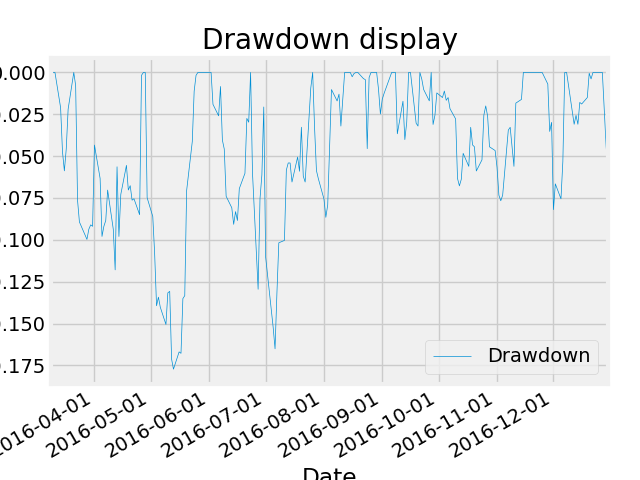

In [15]:
drawdownGraph(df)

Plot the profit loss graph and then actual and prediction decision graph.

<IPython.core.display.Javascript object>


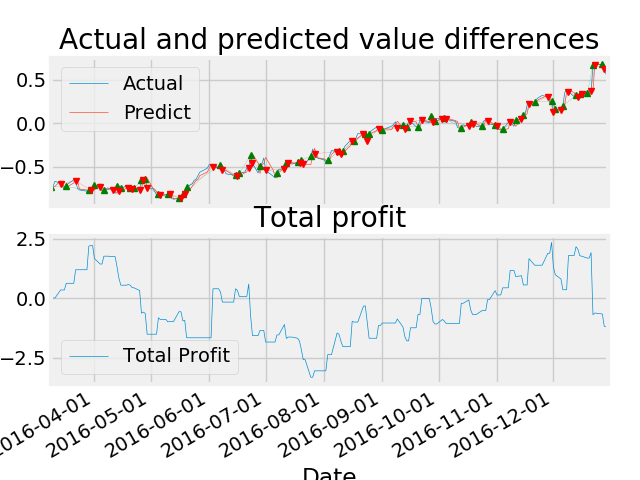

In [16]:
plotGraph(df)

Show the total mae.

In [17]:
maeCalc(df)

Mean absolute error equals  3.339481497947166 %.



Here we are displaying the measurements that are required for grade 5.

In [18]:
measures(df)

The highest profit is:  2.06
The highest lost is:  -2.610001
The max drawdown for profit is:  -0.589699553206
